# Import modules

In [1]:
import os
os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF


In [2]:
from __future__ import division

import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns
from scipy.signal import find_peaks
import scipy.optimize as optimize
import scipy.stats as stats

from grr.cell_class import Cell
from grr import pltools
from ezephys.stimtools import BiexponentialSynapticKernel

# Load data

In [3]:
MINI_SAVE_PATH = './data/processed/5HT/GABA_synapses/detected_minis/'

mini_detectors = []

for fname in os.listdir(MINI_SAVE_PATH):
    with open(MINI_SAVE_PATH + fname, 'rb') as f:
        mini_detectors.append(pickle.load(f))


SAMPLE_TR_PATH = './data/processed/5HT/GABA_synapses/sample_traces/'

with open(SAMPLE_TR_PATH + 'averaged_traces.dat', 'rb') as f:
    averaged_traces = pickle.load(f)

with open(SAMPLE_TR_PATH + 'sample_decay_fit.dat', 'rb') as f:
    sample_tr = pickle.load(f)

# Perform linear fit on I/V data

Extract reversal potential of Cl based on linear fit of IV curves.
Use extracted reversal to calculate mIPSC peak conductance from recorded
currents.

In [4]:
IV_data = {
    'amplitudes': [],
    'voltages': []
}

for i in range(len(averaged_traces['t_mats'])):
    mask = 0 < np.gradient(averaged_traces['voltages'][i])
    IV_data['voltages'].append(averaged_traces['voltages'][i][mask])
    IV_data['amplitudes'].append(averaged_traces['traces'][i][250, mask])

X = np.concatenate(IV_data['voltages'])
X = np.array([X, np.ones_like(X)]).T
Y = np.concatenate(IV_data['amplitudes'])

def linear_fit(X, Y):
    coeffs = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y))
    return coeffs

m, b = linear_fit(X, Y)
IV_coeffs = {
    'slope': m,
    'intercept': b
}
del m, b

reversal = -IV_coeffs['intercept']/IV_coeffs['slope']

def I_to_g(I, V, reversal):
    """Convert current (amperes) to conductance (siemens).

    Note: 1 pA / 1 mV = 1nS

    Inputs:
        I -- float or array of floats
            Current value(s) to convert.
        V -- float
            Voltage at which current was measured.
        reversal -- float
            Reversal potential of the current.

    Returns:
        I / (V - reversal)
    """
    return I/(V - reversal)

# Fit gamma distribution to mIPSC amplitudes

no. minis: 448
no. minis: 308
no. minis: 316


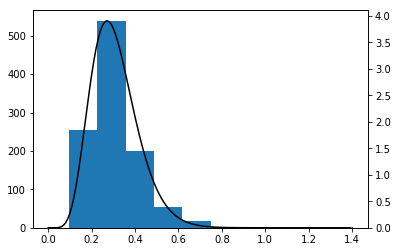

In [5]:
for MiDe in mini_detectors:
    print('no. minis: {}'.format(MiDe.no_minis))

# Since all cells have a similar number of minis, we'll pool all amplitudes.

amplis = np.concatenate([MiDe.amplitudes(5) for MiDe in mini_detectors])
conds = I_to_g(amplis, 20, reversal)
a, loc, scale = stats.gamma.fit(conds, floc = 0)

gamma_params = {
    'a': a,
    'loc': loc,
    'scale': scale
}
del a, loc, scale

plt.figure()

ax = plt.subplot(111)
plt.hist(conds)

ax2 = ax.twinx()
x = np.arange(0, 1.4, 0.01)
ax2.plot(
    x,
    stats.gamma.pdf(x, a = gamma_params['a'], loc = gamma_params['loc'], scale = gamma_params['scale']),
    'k-'
)
ax2.set_ylim(0, ax2.get_ylim()[1])

plt.show()

In [6]:
print('mIPSC amplitude: {:.5f}nS +/- {:.5f}nS'.format(np.mean(conds), stats.sem(conds)))

mIPSC amplitude: 0.30849nS +/- 0.00366nS


# Fit exponential distribution to mIPSC IEIs

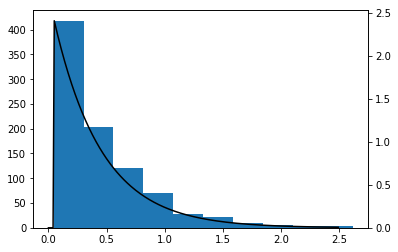

In [7]:
# Again, we'll pool all IEIs here since the count per cell is similar.

IEIs = np.concatenate([MiDe.inter_mini_intervals() * 1e-3 for MiDe in mini_detectors])
loc, scale = stats.expon.fit(IEIs)

expon_params = {
    'loc': loc,
    'scale': scale
}
del loc, scale

ax = plt.subplot(111)
plt.hist(IEIs)

ax2 = ax.twinx()
x = np.arange(0, 2.5, 0.01)
ax2.plot(
    x,
    stats.expon.pdf(x, loc = expon_params['loc'], scale = expon_params['scale']),
    'k-'
)
ax2.set_ylim(0, ax2.get_ylim()[1])

plt.show()

# Make figure

Define some reference timepoints. `stim_time` is the beginning of the stimulus artefact, and `foot_time` is an approximate index of the IPSC start (i.e., `stim_time` + propagation delay).

In [8]:
stim_time = 162
foot_time = 180

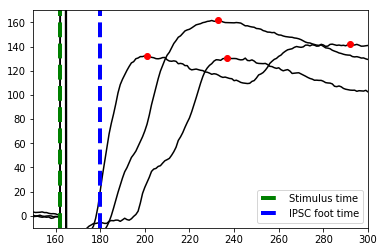

In [9]:
first_peak_times = []

for voltages, tr in zip(averaged_traces['voltages'], averaged_traces['traces']):
    ind = np.argmin(np.abs(voltages - 60.))
    locs, details = find_peaks(tr[(stim_time + 10):, ind], (10, 500), width=2, prominence=2)
    first_peak_times.append((locs[0] + 10 + (stim_time - foot_time)) * 0.1)
    
    plt.plot(tr[:, ind], 'k-')
    plt.plot(locs + 162 + 10, details['peak_heights'], 'ro')
    plt.legend()
    plt.ylim(-10, 170)
    plt.xlim(150, 300)

plt.axvline(stim_time, color='g', ls='--', lw=4, label='Stimulus time')
plt.axvline(foot_time, color='b', ls='--', lw=4, label='IPSC foot time')
plt.legend()

In [10]:
print('First peak times: {}'.format(first_peak_times))
print('First peak times: {:.1f} +/- {:.1f}'.format(np.mean(first_peak_times), stats.sem(first_peak_times)))
print(
    'Decay time constants: {:.1f} +/- {:.1f}'.format(
        np.mean(averaged_traces['decay']), 
        stats.sem(averaged_traces['decay'])
    )
)

First peak times: [2.1, 5.7, 5.300000000000001]
First peak times: 4.4 +/- 1.1
Decay time constants: 26.0 +/- 2.1


## IPSC model

The GIFnet models GABA synapses with a biexponential synaptic kernel.
The decay of the synaptic kernel in GIFnet simulations should obviously be the same as fitted here (26.0ms).
We can calculate the rising time constant of the synaptic kernel as follows.

The biexponential kernel used in GIFnet simulations is defined as
\begin{align}
    I &= e^{-t/\tau_d} - e^{-t/\tau_r} \\
    \frac{\partial I}{\partial t} &= \frac{1}{\tau_r} e^{-t/\tau_r} - \frac{1}{\tau_d} e^{-t/\tau_d}
\end{align}
where $\tau_d$ is the decay time constant and $\tau_r$ is the rising time constant. Setting the derivative to zero gives us a partial solution for $\tau_r$ in terms of $\tau_d$ and the peak time (which we have---ish):
$$ \frac{t}{\tau_d} + \log \tau_d = \frac{t}{\tau_r} + \log \tau_r. $$

**Substituting in $\tau_d = 26.0$ms and $t = 4.4$ms we get $\tau_r = 1.44$ms.**

P.S. The solution for the time to peak $t$ in terms of $\tau_r$ and $\tau_d$ is
$$ t = \frac{1}{\frac{1}{\tau_d} - \frac{1}{\tau_r}} \log \frac{\tau_r}{\tau_d} $$

In [11]:
kernel = BiexponentialSynapticKernel(125, 1.4, 26.0)
_ = kernel.generate(100., 0.1)

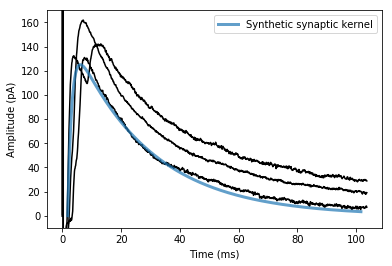

In [12]:
for voltages, tr in zip(averaged_traces['voltages'], averaged_traces['traces']):
    ind = np.argmin(np.abs(voltages - 60.))
    
    plt.plot(np.arange(0, (tr.shape[0] - stim_time) * 0.1, 0.1), tr[stim_time:, ind], 'k-')
    plt.legend()
    plt.ylim(-10, 170)

plt.plot(
    kernel.time_supp + (foot_time - stim_time) * 0.1, 
    kernel.kernel, label='Synthetic synaptic kernel', 
    lw=3, 
    alpha=0.7
)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (pA)')
plt.legend()

The simplified model gives a good fit.

| Parameter | Value |
| :-------: | :---: |
| $\tau_r$  | 1.44ms |
| $\tau_d$  | 26.0ms |
| $g_{syn}$ | 0.3nS  |

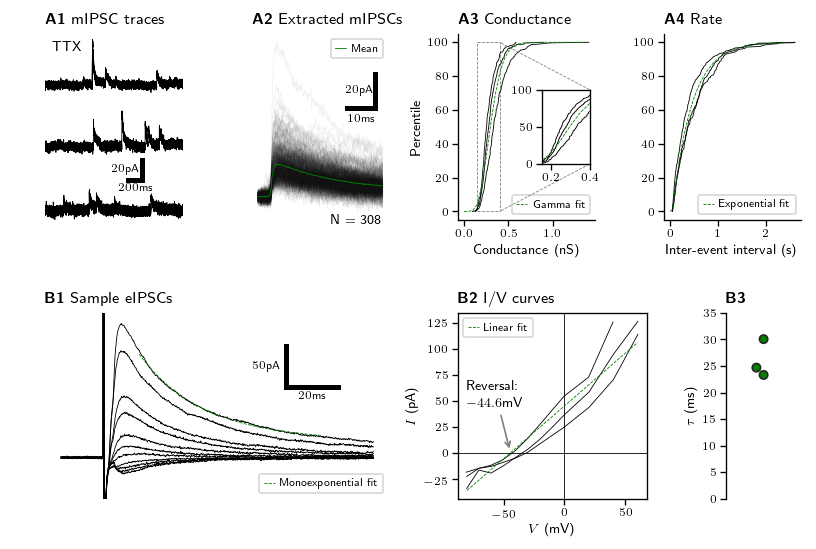

In [13]:
SAVE_PATH = './figs/ims/gaba_synapses/'

sample_minis_tr = 1

def subtract_baseline(arr, samples = 10):
    return np.copy(arr) - arr[:samples, :].mean(axis = 0)

bl_sub_sample_minis = subtract_baseline(mini_detectors[sample_minis_tr].minis)

spec_outer = gs.GridSpec(2, 4, wspace = 0.5, hspace = 0.5, top = 0.9, right = 0.95, left = 0.05)
spec_IV_extracted = gs.GridSpecFromSubplotSpec(1, 2, spec_outer[1, 2:4], width_ratios = [1, 0.4], wspace = 0.6)
spec_mini_tr = gs.GridSpecFromSubplotSpec(3, 1, spec_outer[0, 0], hspace = 0)

plt.style.use('./figs/scripts/writeup/publication_figure_style.dms')
plt.rc('font', size = 8)

plt.figure(figsize = (7, 5))

for i in range(3):
    plt.subplot(spec_mini_tr[i, :])
    if i == 0:
        plt.title('\\textbf{{A1}} mIPSC traces', loc = 'left')
        plt.text(0.05, 0.9, 'TTX', ha = 'left', va = 'top', transform = plt.gca().transAxes)

    plt.plot(mini_detectors[i].t_vec, mini_detectors[i].I[:, 16], 'k-', lw = 0.5)
    plt.ylim(-12, 50)
    plt.xlim(500, 2500)

    if i == 2:
        pltools.add_scalebar(
            x_units = 'ms', y_units = 'pA', x_size = 200, y_size = 20,
            anchor = (0.7, 0.65), bar_space = 0, x_label_space = -0.05)
    else:
        plt.xticks([])
        plt.yticks([])
        pltools.hide_border()


plt.subplot(spec_outer[0, 1])
plt.title('\\textbf{{A2}} Extracted mIPSCs', loc = 'left')
plt.text(
    0.95, 0, 'N = {}'.format(mini_detectors[sample_minis_tr].no_minis),
    ha = 'right', va = 'center', transform = plt.gca().transAxes
)
t_vec = np.arange(
    0,
    mini_detectors[sample_minis_tr].minis.shape[0] * mini_detectors[sample_minis_tr].dt,
    mini_detectors[sample_minis_tr].dt
)
plt.plot(
    np.tile(
        t_vec[:, np.newaxis],
        (1, mini_detectors[sample_minis_tr].no_minis)
    ),
    bl_sub_sample_minis,
    'k-', lw = 0.5, alpha = 0.05
)
plt.plot(t_vec, np.nanmean(bl_sub_sample_minis, axis = 1), 'g-', label = 'Mean')
pltools.add_scalebar(
    x_units = 'ms', y_units = 'pA', anchor = (0.9, 0.6), bar_space = 0,
    x_size = 10, x_label_space = -0.03
)
plt.legend(loc = 'upper right')

cond_ax = plt.subplot(spec_outer[0, 2])
plt.title('\\textbf{{A3}} Conductance', loc = 'left')
for sorted_maxes in [MiDe.amplitudes(5, sort = True) for MiDe in mini_detectors]:
    sorted_gs = I_to_g(sorted_maxes, 20, reversal)
    pctiles = np.linspace(0, 100, len(sorted_maxes))
    plt.plot(sorted_gs, pctiles, 'k-')
x = np.arange(0, 1.4, 0.05)
plt.plot(
    x,
    100 * stats.gamma.cdf(x, a = gamma_params['a'], loc = gamma_params['loc'], scale = gamma_params['scale']),
    'g--', label = 'Gamma fit'
)
cond_ax.set_xticks([0, 0.5, 1])
plt.xlabel('Conductance (nS)')
plt.ylabel('Percentile')
pltools.hide_border('tr')

cond_ins = inset_axes(cond_ax, '35%', '40%', loc = 'center right')
for sorted_maxes in [MiDe.amplitudes(5, sort = True) for MiDe in mini_detectors]:
    sorted_gs = I_to_g(sorted_maxes, 20, reversal)
    pctiles = np.linspace(0, 100, len(sorted_maxes))
    cond_ins.plot(sorted_gs, pctiles, 'k-')
x = np.arange(0, 1.4, 0.05)
cond_ins.plot(
    x,
    100 * stats.gamma.cdf(x, a = gamma_params['a'], loc = gamma_params['loc'], scale = gamma_params['scale']),
    'g--', label = 'Gamma fit'
)
cond_ins.set_xlim(0.15, 0.4)
cond_ins.set_ylim(0, 100)

mark_inset(cond_ax, cond_ins, loc1 = 1, loc2 = 4, ls = '--', color = 'gray', lw = 0.5)
cond_ax.legend(loc = 'lower right')


plt.subplot(spec_outer[0, 3])
plt.title('\\textbf{{A4}} Rate', loc = 'left')
for sorted_IMIs in [MiDe.inter_mini_intervals(sort = True) for MiDe in mini_detectors]:
    sorted_IMIs /= 1e3 # Convert to s
    pctiles = np.linspace(0, 100, len(sorted_IMIs))
    plt.plot(sorted_IMIs, pctiles, 'k-')
x = np.arange(0, 2.5, 0.05)
plt.plot(
    x,
    100 * stats.expon.cdf(x, loc = expon_params['loc'], scale = expon_params['scale']),
    'g--', label = 'Exponential fit'
)
plt.xlabel('Inter-event interval (s)')
plt.legend(loc = 'lower right')
pltools.hide_border('tr')


plt.subplot(spec_outer[1, :2])
plt.title('\\textbf{{B1}} Sample eIPSCs', loc = 'left')
plt.plot(
    averaged_traces['t_mats'][sample_tr['ind']][:, :-2],
    averaged_traces['traces'][sample_tr['ind']][:, :-2],
    'k-', lw = 0.5
)
plt.plot(sample_tr['x_fit'], sample_tr['y_fit'], 'g--', label = 'Monoexponential fit')
#plt.plot(kernel.time_supp + foot_time * 0.1, kernel.kernel, label='Synthetic IPSC', lw=4, alpha=0.5)
plt.ylim(-50, 175)
pltools.add_scalebar(
    x_units = 'ms', y_units = 'pA', x_size = 20, y_size = 50, bar_space = 0,
    x_on_left = False, anchor = (0.7, 0.6)
)
plt.legend(loc = 'lower right')

plt.subplot(spec_IV_extracted[:, 0])
plt.title('\\textbf{{B2}} I/V curves', loc = 'left')
plt.axhline(0, color = 'k', lw = 0.5)
plt.axvline(0, color = 'k', lw = 0.5)
for i in range(len(IV_data['amplitudes'])):
    plt.plot(
        IV_data['voltages'][i],
        IV_data['amplitudes'][i],
        'k-'
    )
x_linear = np.array([[-80, 1], [60, 1]])
plt.plot(
    x_linear[:, 0],
    np.dot(x_linear, np.array([IV_coeffs['slope'], IV_coeffs['intercept']])),
    'g--', label = 'Linear fit'
)
plt.annotate(
    'Reversal:\n${:.1f}$mV'.format(reversal),
    (reversal, 1),
    (0.05, 0.5),
    xycoords = 'data',
    textcoords = 'axes fraction',
    arrowprops = {'arrowstyle': '->'}
)
plt.xlabel('$V$ (mV)')
plt.ylabel('$I$ (pA)')
plt.legend()


plt.subplot(spec_IV_extracted[:, 1])
plt.title('\\textbf{{B3}}', loc = 'left')
plt.ylim(0, 35)
sns.swarmplot(y = averaged_traces['decay'], color = 'g', edgecolor = 'gray', linewidth = 1)
plt.xticks([])
plt.ylabel('$\\tau$ (ms)')
pltools.hide_border('trb')

if SAVE_PATH is not None:
    plt.savefig(SAVE_PATH + 'gaba_synapses.png')

plt.show()